<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/gru_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from tqdm import tqdm

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [3]:
print(X_train.shape, y_train.shape)

(7000, 50, 1) (7000, 1)


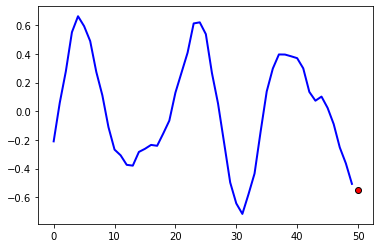

In [4]:
time_stamps = np.arange(n_steps + 1)
plt.plot(time_stamps[:-1], X_train[0], c="b", lw=2.0)
plt.scatter(time_stamps[-1], y_train[0], ec="k", color="r")

In [5]:
class TimeseriesData(torch.utils.data.Dataset):
    def __init__(self, n_steps, n_series, n_pred_steps=1):
        data, labels = self.generate_time_series(n_series,
                                                 n_steps,
                                                 n_pred_steps)
        self.inputs = torch.tensor(data)
        self.targets = torch.tensor(labels)

    def __getitem__(self, idx):
        return {"inputs": self.inputs[idx],
                "targets": self.targets[idx]}
    
    def __len__(self):
        return min(len(self.inputs), len(self.targets))

    def generate_time_series(self, n_series, n_steps, n_pred_steps):
        freq1, freq2, offsets1, offsets2 = np.random.rand(4, n_series, 1)
        time = np.linspace(0, 1, n_steps + n_pred_steps)
        series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
        series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
        series += 0.1 * (np.random.rand(n_series, n_steps + n_pred_steps) - 0.5) # + noise
        series = series[..., np.newaxis].astype(np.float32)
        return series[:, :n_steps], series[:, n_steps:]


In [35]:
n_pred_steps = 4*n_steps
train_data = TimeseriesData(n_steps, n_series=70000, n_pred_steps=n_pred_steps) 
test_data = TimeseriesData(n_steps, n_series=20000, n_pred_steps=n_pred_steps) 
val_data = TimeseriesData(n_steps, n_series=10000, n_pred_steps=n_pred_steps)

(50, 1) (200, 1)


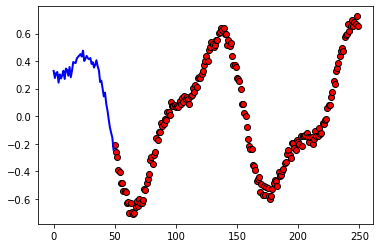

In [36]:
# sanity check
rng = np.random.default_rng()
idx = rng.integers(0, len(train_data))
inputs = train_data[idx]["inputs"].numpy()
targets = train_data[idx]["targets"].numpy()
print(inputs.shape, targets.shape)
time_stamps = np.arange(n_steps)
time_stemps_pred = np.arange(n_steps, n_steps + n_pred_steps)

plt.plot(time_stamps, inputs, c="b", lw=2.0)
plt.scatter(time_stemps_pred, targets, ec="k", color="r")
plt.show()

In [37]:
class GRUPredictor(torch.nn.Module):
    def __init__(self, input_size, hidden_size, *args):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = torch.nn.GRUCell(input_size, hidden_size, bias=True)
        self.linear = torch.nn.Linear(hidden_size, input_size)                                    
        pass
    
    def forward(self, inputs, num_steps):
        inputs = inputs.swapaxes(0, 1) # batch, time, dim -> time, batch, dim
        h = torch.zeros((inputs.shape[1], self.hidden_size),
                         device=inputs.device)
        # warm-up
        T = inputs.shape[0]
        for t in range(T-1):
            h = self.gru(inputs[t], h)
        # prediction
        outputs = []
        input_t = inputs[-1]
        for t in range(num_steps):
            h = self.gru(input_t, h)
            output_t = self.linear(h)
            outputs.append(output_t)
            input_t = output_t
        outputs = torch.stack(outputs)
        outputs = outputs.swapaxes(0, 1) # time, batch, dim -> batch, time, dim
        return outputs

In [38]:
def evaluate(model, val_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", torch.nn.functional.mse_loss)
    device = kwargs.get("device", torch.device("cpu"))

    model.eval()
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    avg_loss = 0.
    for i, batch in pbar:
        batch["inputs"] = batch["inputs"].to(device)
        batch["targets"] = batch["targets"].to(device)
        num_steps = batch["targets"].shape[1] # batch_size, time, dim
        with torch.no_grad(): # no need to compute gradients
            preds = model(batch["inputs"], num_steps)
        loss = loss_fn(preds, batch["targets"])
        avg_loss += loss.item()
        pbar.set_description(f"loss = {loss:.5f}")
    avg_loss /= len(val_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get("num_epochs", 100)
    loss_fn = kwargs.get("loss_fn", torch.nn.functional.mse_loss)
    device = kwargs.get("device", torch.device("cpu"))
    
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        print("Training phase...")
        model.train() # set model to training mode
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            batch["inputs"] = batch["inputs"].to(device)
            batch["targets"] = batch["targets"].to(device)

            model.zero_grad() # initialize gradients to zero

            num_steps = batch["targets"].shape[1] 
            preds = model(batch["inputs"], num_steps) # forward pass
            loss = loss_fn(preds, batch["targets"]) # loss computation
            loss.backward() # computing gradients (backward pass)
            optimizer.step() # updating the parameters of the model

            train_loss += loss.item() # accumulate loss across batch
            pbar.set_description(f"loss = {loss:.5f}")

        train_loss /= len(train_loader) # average batch loss
        print(f"train loss = {train_loss:.5f}")
        train_loss_hist.append(train_loss)
        
        print("Validation phase...")
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"validation loss = {val_loss:.5f}")
        val_loss_hist.append(val_loss)
        
    return train_loss_hist, val_loss_hist

In [39]:
HIDDEN_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("DEVICE:", DEVICE)
# we should shuffle our data at beggining of each epoch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = GRUPredictor(train_data[0]["inputs"].shape[1], HIDDEN_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: cuda


In [ ]:
train_loss, val_loss = fit(model, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 1/5
Training phase...


loss = 0.12000:  66%|██████▌   | 1438/2188 [01:59<01:02, 12.00it/s]

In [ ]:
plt.title("Train and validation losses")
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(val_loss)), val_loss, label="validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss = evaluate(model, val_loader, device=DEVICE)
print(f"Test loss = {test_loss:.5f}")

In [ ]:
def predict(model, data_loader, **kwargs):
    num_steps = kwargs.get("num_steps", 24)
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval()
    preds = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:
        batch["inputs"] = batch["inputs"].to(device)
        batch["targets"] = batch["targets"].to(device)
        num_steps = batch["targets"].shape[1] # batch_size, time, dim
        with torch.no_grad(): # no need to compute gradients
            batch_preds = model(batch["inputs"], num_steps)
        for pred in batch_preds: # store each prediction from batch
            preds.append(pred.cpu())
    return preds

In [ ]:
test_preds = predict(model, test_loader, num_steps=n_pred_steps, device=DEVICE)

In [ ]:
rng = np.random.default_rng()
idx = rng.integers(0, len(test_data))
inputs = test_data[idx]["inputs"].numpy()
targets = test_data[idx]["targets"].numpy()
preds = test_preds[idx].numpy()
print(inputs.shape, targets.shape)
time_stamps = np.arange(n_steps)
time_stamps_pred = np.arange(n_steps, n_steps + n_pred_steps)

i = 0
plt.plot(time_stamps, inputs[:, i], label="input")
plt.plot(time_stamps_pred, targets[:, i], label="target")
plt.plot(time_stamps_pred, preds[:, i], label="prediction")
plt.legend()
plt.show()